# Questions Clustering

## Expected
Questions to be sorted out such that the response to the whole cluster is samel.

<!--### To Do-->
Author: Sunanda Bansal  
Organization: Dataperformers  
License: CC BY-NC  
Date: 24 Mar, 2020 (Start)  

In [42]:
import re
import os
import csv
import sys
import json
import time
import nltk
import scipy
import socket
import pickle
import numpy as np
import pandas as pd
import multiprocessing as mp

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer   
from sklearn import metrics   
from sklearn.metrics import confusion_matrix
# from sklearn.metrics.pairwise import paired_distances as sklearn_paired_distances

# Plotting
import seaborn as sn
import matplotlib.pyplot as plt

# importing personal development helper classes
import utils

## Define variables here

Mostly the code will be intended to use with arguments that can be passed in comman line, but jupyter notebook doesn't handle `argparse` well, so the Args class is a temporary way to write the code assumming the variables to be an attribute of an object.

In [43]:
class Args:
    def __init__(self):
        # The very big scraped file, give absolute path, outside the repo
        self.dataset = "data/train_set_covid.csv"
        self.vector_mode = "tfidf"
        self.n_topics = 15
        self.repr_method = "lsi"
        self.lang = "fr"
args=Args()

In [44]:
# Disable (FALSE) displaying warnings from the OpenMP* run-time library during program execution.
os.environ['KMP_WARNINGS'] = "FALSE"

## Reading Dataset

In [45]:
dataset = pd.read_csv(args.dataset)

In [46]:
dataset.head()

,timestamp_est,anonymous_id,language,question
0,2020-03-22 10:55:35.958,dfc284f8-e162-44fe-b6ab-4dc25083293e,es,Are you sick?
1,2020-03-21 22:41:05.702,7a8ef480-4e63-429e-b7ff-4763ad47cfe2,pt,When should I go to the hospital?
2,2020-03-22 20:44:40.577,b3923f7c-ea90-4af2-94c5-5ee8736975fd,ko,I think I have a fever. What do I do?
3,2020-03-21 23:21:56.689,8e750805-9fc2-4702-a244-0b7e67cf29ad,vi,1+1
4,2020-03-22 11:24:07.614,7977f4b9-e495-45f7-a5ca-841359f618ac,es,What's covid19?


## Preprocess

In [47]:
# Will add later, right now, leaving it to the utils doc2vec

In [48]:
def detect_lang(text):
    try:
        return detect(text)
    except:
        return "unidentifiable"

In [49]:
from langdetect import detect
dataset["detected_lang"] = dataset.question.apply(detect_lang)

In [50]:
dataset = dataset[dataset.detected_lang == args.lang]

In [58]:
import re
regex = re.compile('[^a-zA-Z]')

from nltk.corpus import stopwords as sw
if args.lang == "en": stopwords = sw.words('english')
if args.lang == "fr": stopwords = sw.words('french')

from nltk.stem.snowball import SnowballStemmer
if args.lang == "en": stemmer = SnowballStemmer("english")
if args.lang == "fr": stemmer = SnowballStemmer("english")

def tokenize(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            clean_words = regex.sub(' ', word).split()
            tokens.extend([word.lower() for word in clean_words])
    return tokens


def stem(word):
    return stemmer.stem(word).strip()


def preprocess(text):    
    tokenized = tokenize(text)
    cleaned = [word for word in tokenized if word not in stopwords and word is not '']
#     stemed = [stem(word) for word in cleaned]
    #stemed = [stem(word) for word in tokenized]
    #corpus[i] = ' '.join(tokenized)
    return ' '.join(tokenized)

In [59]:
# import nltk

dataset["cleaned_question"] = dataset.question.apply(preprocess)

In [60]:
dataset.head()

,timestamp_est,anonymous_id,language,question,detected_lang,cleaned_question
6,2020-03-21 19:50:01.242,ceae6bf7-a5ec-4832-934d-211ebc182948,es,Le virus est-il aussi virulent dans les pays p...,fr,le virus est il aussi virulent dans les pays p...
16,2020-03-21 19:50:01.266,ceae6bf7-a5ec-4832-934d-211ebc182948,es,L'automédication peut-elle aider à vaincre la ...,fr,l autom dication peut elle aider vaincre la ma...
30,2020-03-22 17:53:53.649,5c6d77d5-4e2a-4a3e-838d-1dce011b2631,fr,Est-ce que caresser le chien de nos amis peut ...,fr,est ce que caresser le chien de nos amis peut ...
31,2020-03-22 22:25:32.067,9f6c857a-c6da-498d-93ad-237e8310394d,fr,comment le virus se propage-t-il?,fr,comment le virus se propage t il
32,2020-03-22 01:41:10.762,3c16663e-dc8b-48f7-8168-d98020a0178e,fr,Durée du confinement,fr,dur e du confinement


In [12]:
# import nltk
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=5000,
#                                  min_df=0.05, stop_words="english",
#                                  use_idf=True, tokenizer=tokenize,
#                                   lowercase=True)

# tfidf_matrix = tfidf_vectorizer.fit_transform(dataset.question)

## LSI

In [14]:
model = utils.text.representation.LSI(args)

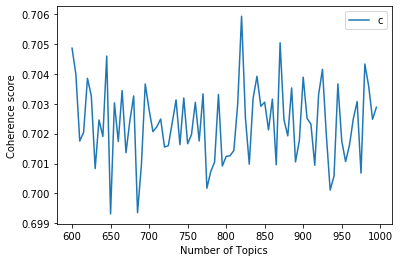

In [28]:
# results = model.plot_graph(dataset.question,600,1000,5)

In [29]:
results_600_1000_5 = results

In [30]:
pickle.dump(results_300_600_5,open("output/pickle/lsa_coherence_600_1000_5.p","wb"))

In [ ]:
# model.plot_graph(dataset.question,5,8,1)

In [65]:
results

In [23]:
args.n_topics = 230

In [25]:
dataset["embedding"] = model.generate_embedding(dataset.question, returnarray=False)

## LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
for n in range(5,30):
    lda = LatentDirichletAllocation(n_components=n, random_state=42)
    lda.fit(tfidf_matrix)
    topic_values = lda.transform(tfidf_matrix)
    dataset[f"lda_{n}n_label"] = topic_values.argmax(axis=1)
    dataset[f"embedding_{n}n"] = list(topic_values)

In [ ]:
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(tfidf_matrix)
topic_values = lda.transform(tfidf_matrix)
dataset[f"lda_label"] = topic_values.argmax(axis=1)
dataset[f"embedding"] = list(topic_values)

In [ ]:
dataset.columns[dataset.columns.str.contains("embedding")]

In [ ]:
dataset[["question","lda_15n_label"]].sort_values("lda_15n_label")

In [ ]:
dataset.head()

### Kmeans

In [ ]:
for col in dataset.columns[dataset.columns.str.contains("embedding_")]:
    for n in range(5,20):
        kmeans = KMeans(n_clusters=n, random_state=42).fit(list(dataset[col]))
        dataset[f"{n}km_{col.replace('embedding_','')}lda"] = list(kmeans.labels_)
#         dataset.reset_index()\
#                .pivot(index="index",columns=f"kmeans_{n}n_label", values="question")\
#                .fillna("-")\
#                .to_csv(f"output/km_{n}n_lda_{col.replace('embedding_','')}.csv")

In [ ]:
kmeans = KMeans(n_clusters=15, random_state=42).fit(list(dataset["embedding"]))
dataset["kmeans_label"] = list(kmeans.labels_)

In [ ]:
dataset.groupby("kmeans_label").count()

In [ ]:
dataset.sort_values("kmeans_label")

In [ ]:
for label in dataset.kmeans_label.unique():
    print(dataset[dataset.kmeans_label==label][:10].question)

In [ ]:
counts = pd.DataFrame(list(dataset.groupby("kmeans_label")["question"].apply(list))).T.count().to_frame("Count")

In [ ]:
counts.T.append(pd.DataFrame(list(dataset.groupby("kmeans_label")["question"].apply(list))).T.fillna("-")).add_prefix("cluster_#").to_csv("output/clusters_15KMeans_lsa.csv")

In [ ]:
pd.DataFrame(list(dataset.groupby("kmeans_label")["question"].apply(list))).T.fillna("-").add_prefix("cluster_#")

### Agglomerative Clustering

In [62]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
X = pd.DataFrame(dataset["embedding"].values.tolist(), index= dataset.index).to_numpy()
clustering = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=2.7).fit(X)
dataset["ahc_label"] = clustering.labels_
dataset.groupby("ahc_label")["question"].count().sort_values()

ahc_label
16      6
15      6
13      7
14      7
18      8
5       8
21      8
22     10
19     11
17     11
7      11
6      12
12     14
1      16
9      16
8      17
11     18
10     20
20     22
3      25
2      27
4      44
0     359
Name: question, dtype: int64

In [63]:
dataset.groupby("ahc_label")["question"].count().describe()

count     23.000000
mean      29.695652
std       72.319641
min        6.000000
25%        8.000000
50%       12.000000
75%       19.000000
max      359.000000
Name: question, dtype: float64

In [59]:
for label in dataset.ahc_label.unique():
    print(f"\ncluster_#{label}\n-----------")
    print(dataset[dataset.ahc_label==label][:10].question.values)


cluster_#6
-----------
['When should I go to the hospital?' 'how is going' 'Where should I go?'
 'should I go to the hospital?'
 "Should I go to the ER or my physician directly if I'm infected?"
 'When will it be ok to go outside?'
 'if i have symptoms should i go to the ER or should I call a doctor?'
 'What is the nearest hospital to go to if I have a COVID-19?'
 'When should I go to the ER?' 'Is it ok to go outside to get fresh air?']

cluster_#18
-----------
['I think I have a fever. What do I do?'
 'I think I have coronavirus, should I go to the emergency'
 'I think I’m sick' "What should I do if i think that i'm infected ?"
 'I think I have COVID'
 'How long do you think we will have to be in a lockdown '
 'what should I do if I think I infected by corona virus?'
 'What to do if I think I have covid 19?']

cluster_#7
-----------
["What's covid19?" 'What is Covid19'
 'What are the symptoms of the covid19?' "What's covid19? " 'covid19'
 'What are the symptoms of covid19' 'What are 

In [50]:
dataset.sort_values("ahc_label")[["question","ahc_label"]]

,question,ahc_label
1852,"If I cross someone on the street, how are the ...",0
1319,Shall we stay where we are or travel to our ho...,0
722,Could stores open a few hours a week for the e...,0
720,how much does corona virus stay on each kind o...,0
1321,What colour is covid 19?,0
1322,Why does the government think that we don't ne...,0
1323,How long does COVID-19 live on glass surfaces?,0
1327,What is the situation right now in the world?,0
710,When should I consult after the vomitting sym...,0
727,How long does the virus stay in paper money an...,0


In [35]:
dataset.sort_values("ahc_label")[["question","ahc_label"]].to_csv("output/230lsa_ahc_1.5DT.csv")

In [36]:
counts = pd.DataFrame(list(dataset.groupby("ahc_label")["question"].apply(list))).T.count().to_frame("Count")

In [38]:
# pd.DataFrame(list(dataset.groupby("ahc_label")["question"].apply(list))).T.count().add_prefix("cluster_#")

In [39]:
visual = counts.T.append(pd.DataFrame(list(dataset.groupby("ahc_label")["question"].apply(list))).T.fillna("-")).add_prefix("cluster_#")

In [40]:
visual.head()

,cluster_#0,cluster_#1,cluster_#2,cluster_#3,cluster_#4,cluster_#5,cluster_#6,cluster_#7,cluster_#8,cluster_#9,...,cluster_#125,cluster_#126,cluster_#127,cluster_#128,cluster_#129,cluster_#130,cluster_#131,cluster_#132,cluster_#133,cluster_#134
Count,9,4,5,46,4,5,16,5,4,6,...,4,3,6,2,2,3,2,3,2,3
0,Does covid-19 test anonymous?,Will it get better in summer with higher tempe...,How do we best organize people so that duplica...,What are the synthoms?,Can COVID-19 stay alive on fresh fruit and veg...,Will Covid19 go away like the 1918 influenza a...,if my tempreture is over 39 can i assume that ...,"If I’m sneezing, should I get tested for coron...",Where can we find ventilator?,How to avoid exposure?,...,How many cases in Montreal?,how many people positive result with COVID-19,How to protect my family from COVID-19?,How many days should I isolate for,What COVID-19 stands for?,When should I visit a doctor?,From the infected worldwide population what is...,Does a throat feel itchy or really sore and a ...,When will it be ok to go outside?,Can the Covid survive in the air?
1,Where are the testing centers located in Mtl?,Could stores open a few hours a week for the e...,How am I supposed to work while I have two you...,covid19 symptons?,Do I need to wash my vegetables and fruits?,what are the conditions under which people are...,What are the most common symptoms of COVID-19?,"If there are kids around me, do I have to worr...",Why is it called Corona virus?,Should I star home and even avoid going to the...,...,How many cases in Montreal,how many case positive with COVID-19 ?,How to protect myself on a plane,How many days does it take to see the symptoms,COVID-19 stands for what?,When should I contact a doctor?,From the infected worldwide population what wi...,Is itchy throat sign of covid 19,Is it ok to go outside to get fresh air?,Is COVID-19 air-borne?
2,which hospital takes the test for covid 19?,is the liquor store open?,When will we be back to work?,What is it,Does washing clothes in the washing machine p...,I would like clarifications about the fact tha...,What are the early symptoms of COVID-19,Should I be worried about getting sick if the ...,Why is called COVID-19,Will NHS workers be even more isolated because...,...,How many case in montreal,how many people positive with Covid-19 in the ...,how to protect myself from it,-,-,Do I need to be seen by a doctor,-,I am feeling itchy around my body. Is it a sym...,-,Does covid transfer through air?
3,Is the test covered in in CIHIP?,could we have done better?,"What are the demographics of people infected, ...",What is,Is it transmissible through anal sex ?,What are the symptoms of SARS-COV-2,What are the real symptoms of covid-19,"im sneezing, should i be worried?","should I call to find out more, it’s the cough...",Is it true that you can get the virus again ev...,...,How many cases in Montreal,-,How can I protect myself from the covid-19?,-,-,-,-,-,-,-


In [41]:
visual.to_csv("output/clusters_ahc_1.5DT_230lsa.csv")

In [ ]:
.to_csv("output/clusters_15KMeans_lsa.csv")

In [ ]:
for col in dataset.columns[dataset.columns.str.contains("embedding_")]:
    for n in range(5,20):
        clustering = AgglomerativeClustering(n_clusters=n).fit(X)
        dataset[f"{n}ahc_{col.replace('embedding_','')}lda"] = clustering.labels_
#         dataset.sort_values("ahc_label")[["question","ahc_label"]].to_csv(f"output/ahc_clustered_n{n}.csv")

In [ ]:
dataset.sort_values("13ahc_5nlda")[["question","13ahc_5nlda"]]

In [ ]:
dataset.columns[dataset.columns.str.contains("10ahc")]